Fetching player data for EPL 2014 season...
Player data saved to epl_players_data_2014_2015.json.
Fetching player data for EPL 2015 season...
Player data saved to epl_players_data_2015_2016.json.
Fetching player data for EPL 2016 season...
Player data saved to epl_players_data_2016_2017.json.
Fetching player data for EPL 2017 season...
Player data saved to epl_players_data_2017_2018.json.
Fetching player data for EPL 2018 season...
Player data saved to epl_players_data_2018_2019.json.
Fetching player data for EPL 2019 season...
Player data saved to epl_players_data_2019_2020.json.
Fetching player data for EPL 2020 season...
Player data saved to epl_players_data_2020_2021.json.
Fetching player data for EPL 2021 season...
Player data saved to epl_players_data_2021_2022.json.
Fetching player data for EPL 2022 season...
Player data saved to epl_players_data_2022_2023.json.
Fetching player data for EPL 2023 season...
Player data saved to epl_players_data_2023_2024.json.
Normality test (Pre/

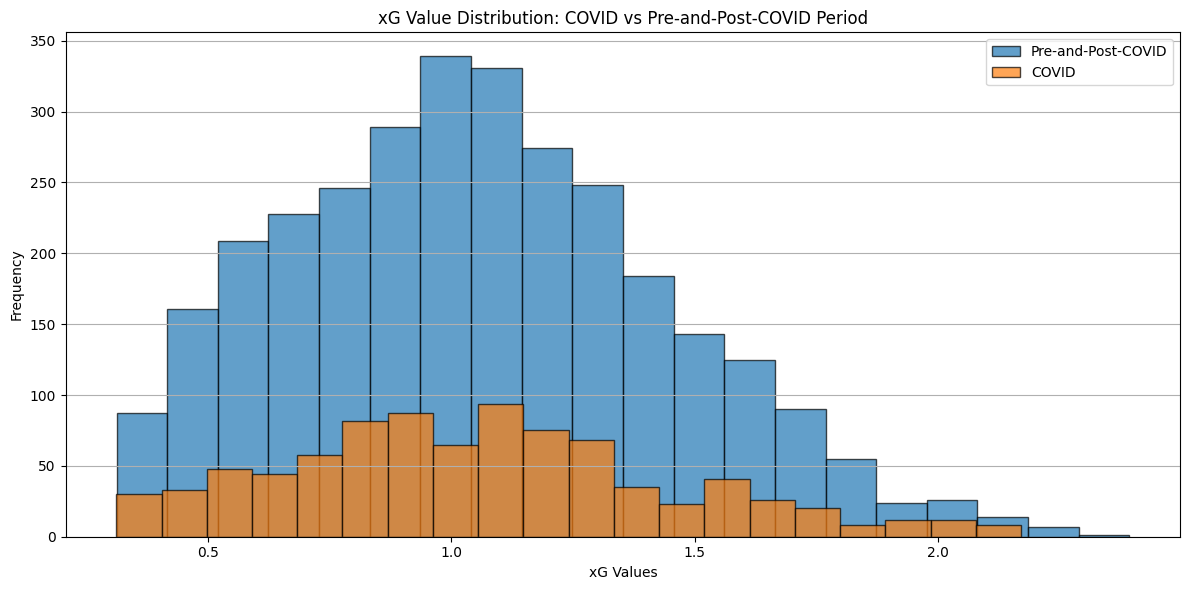

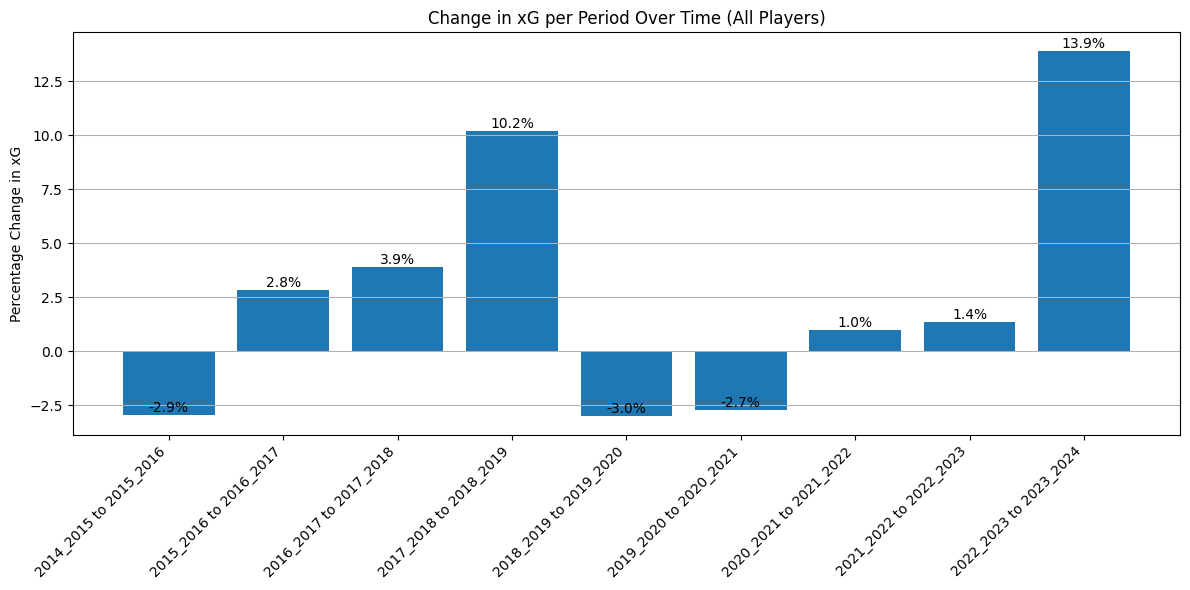

In [1]:
from scipy.stats import ttest_ind, normaltest, levene, mannwhitneyu
from src.utility import load_or_fetch_players_data, get_players

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants for data files and league
data_files = {
    "2014_2015": 'epl_players_data_2014_2015.json',
    "2015_2016": 'epl_players_data_2015_2016.json',
    "2016_2017": 'epl_players_data_2016_2017.json',
    "2017_2018": 'epl_players_data_2017_2018.json',
    "2018_2019": 'epl_players_data_2018_2019.json',
    "2019_2020": 'epl_players_data_2019_2020.json',
    "2020_2021": 'epl_players_data_2020_2021.json',
    "2021_2022": 'epl_players_data_2021_2022.json',
    "2022_2023": 'epl_players_data_2022_2023.json',
    "2023_2024": 'epl_players_data_2023_2024.json',
}
league = 'EPL'

# Load and process player data
xg_data = {}
for season, file_name in data_files.items():
    data = load_or_fetch_players_data(file_name, league, season.split("_")[0])
    players = get_players(data)

    # Convert 'xG' to numeric, any errors to NaN
    players['xG'] = pd.to_numeric(players['xG'], errors='coerce')
    
    # Drop NaN and grab any xG > 0
    xg_data[season] = players['xG'].dropna()[players['xG'] > 0]

# Combine data into groups
covid_xg = pd.concat([xg_data["2019_2020"], xg_data["2020_2021"]])
pre_and_post_covid_xg = pd.concat([
    xg_data["2014_2015"], xg_data["2015_2016"], xg_data["2016_2017"], 
    xg_data["2017_2018"], xg_data["2018_2019"], xg_data["2021_2022"], 
    xg_data["2022_2023"]
])

# Apply transformation as the data is left skewed.
covid_xg = np.sqrt(np.sqrt(covid_xg))
pre_and_post_covid_xg = np.sqrt(np.sqrt(pre_and_post_covid_xg))

# Check normality
stat_normal_pre_post, p_normal_pre_post = normaltest(pre_and_post_covid_xg)
stat_normal_covid, p_normal_covid = normaltest(covid_xg)

# Check variance
stat_levene, p_levene = levene(pre_and_post_covid_xg, covid_xg)

# Choose appropriate statistical test
if p_normal_pre_post > 0.05 and p_normal_covid > 0.05:
    equal_var = p_levene > 0.05
    stat_test, p_test = ttest_ind(pre_and_post_covid_xg, covid_xg, equal_var=equal_var)
    test_name = "t-test"
else:
    stat_test, p_test = mannwhitneyu(pre_and_post_covid_xg, covid_xg, alternative='two-sided')
    test_name = "Mann-Whitney U Test"

# Display results
print(f"Normality test (Pre/Post-COVID): p-value = {p_normal_pre_post:.4f}")
print(f"Normality test (COVID): p-value = {p_normal_covid:.4f}")
print(f"Levene's test for equal variances: p-value = {p_levene:.4f}")
print(f"{test_name}: statistic = {stat_test:.4f}, p-value = {p_test:.4f}")

if p_test < 0.05:
    print("Statistically significant difference in xG between COVID and non-COVID periods.")
else:
    print("No statistically significant difference in xG between COVID and non-COVID periods.")

# Plot histograms for comparison
plt.figure(figsize=(12, 6))
plt.hist(pre_and_post_covid_xg, bins=20, alpha=0.7, label="Pre-and-Post-COVID", edgecolor='black')
plt.hist(covid_xg, bins=20, alpha=0.7, label="COVID", edgecolor='black')
plt.xlabel("xG Values")
plt.ylabel("Frequency")
plt.title("xG Value Distribution: COVID vs Pre-and-Post-COVID Period")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Calculate percentage change per season
xg_means = {season: xg_data[season].mean() for season in xg_data}
percentage_change = {
    f"{prev} to {curr}": ((xg_means[curr] - xg_means[prev]) / xg_means[prev]) * 100
    for prev, curr in zip(xg_means.keys(), list(xg_means.keys())[1:])
}

# Plot xG percentage changes
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(percentage_change)), list(percentage_change.values()))
plt.xticks(range(len(percentage_change)), list(percentage_change.keys()), rotation=45, ha='right')  # Align labels with bars
plt.ylabel("Percentage Change in xG")
plt.title("Change in xG per Period Over Time (All Players)")
plt.grid(axis='y')

# Add percentage labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height,
        f"{height:.1f}%", ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()
